In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
imports time
from DUT import DUT
import matplotlib.pyplot as plt
import numpy as np
import json
import sys

import pandas as pd

from tqdm import tqdm

In [3]:
my_dut = DUT(20, True, 3.2)

In [4]:
n_train = 5000
n_test = 20000 - n_train

In [5]:
meastime, nmeas, nport, meas, ports, expyield = my_dut.info()
print("DUT: meas. time= ", meastime, " | measurements= ", nmeas, " | ports= ", nport, " | expected yield = ", expyield)

DUT: meas. time=  128.43814099999997  | measurements=  45  | ports=  12  | expected yield =  3.2


In [6]:
error_count = 0
X = []
Y = []
t=0

data= {}
data['component']=[]

In [7]:
fails = []
my_err = 0

In [8]:
for x in range(n_train):    
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]
    
    if x % 500 == 0:
        my_dut.calibrate()
        
    toggle = True

    for i in range(0, nmeas):
        t, result, dist = my_dut.gen_meas_idx(i)
        
        if dist > 1: fails.append(i)
        
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
                
        if result == False and toggle:
            toggle = False
            my_err += 1
            break

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  0.1  took  532.1566359999999  seconds.
Calibration at  61151.27853100077  took  532.1566359999999  seconds.
Calibration at  122614.4770180065  took  532.1566359999999  seconds.
Calibration at  184496.5206400161  took  532.1566359999999  seconds.
Calibration at  245693.0115680265  took  532.1566359999999  seconds.
Calibration at  307608.49596999836  took  532.1566359999999  seconds.
Calibration at  369000.70101795666  took  532.1566359999999  seconds.
Calibration at  430807.38640691485  took  532.1566359999999  seconds.
Calibration at  491908.1837528741  took  532.1566359999999  seconds.
Calibration at  554120.7952228454  took  532.1566359999999  seconds.


In [9]:
a, c = np.unique(fails, return_counts=True)
indexes = np.zeros(nmeas)
indexes[a] = c
sorted_meas = np.argsort(-indexes)

sorted_meas #= sorted_meas # [:-sum(indexes < 1)]

array([ 2, 29, 40, 37, 11,  3, 21, 36, 14,  6,  4,  9, 42, 20,  7, 16, 34,
       18, 10, 19, 35, 26, 38, 23, 41, 30, 39, 31,  0, 22, 27, 15, 13,  1,
       44, 25, 33, 24, 43, 17, 12,  8, 28, 32,  5])

In [10]:
for x in range(n_test):
    my_dut.new_dut()
    dut={}
    dut['dut_id'] = x
    dut['measurements']=[]

    if x % 500 == 0:
        my_dut.calibrate()
    
    incount = True
    for j, i in enumerate(sorted_meas):
        t, result, dist = my_dut.gen_meas_idx(i, incount)
        measurement = {}
        measurement['m_id'] = i
        measurement['m_time'] = meas[i].meas_time
        measurement['m_result'] = dist
        dut['measurements'].append(measurement)
        
        if result == False or j > nmeas - sum(indexes < 1):
            if result == False and incount:
                my_err +=1
            incount = False

    t, res, dist = my_dut.get_result()
    dut['dut_result'] = res

    data['component'].append(dut)

    X.append(t)
    Y.append(dist)
    if not res:
        error_count += 1

Calibration at  616536.4202848314  took  532.1566359999999  seconds.
Calibration at  677500.944390818  took  532.1566359999999  seconds.
Calibration at  736231.2281838056  took  532.1566359999999  seconds.
Calibration at  795105.8440837921  took  532.1566359999999  seconds.
Calibration at  855497.7817667788  took  532.1566359999999  seconds.
Calibration at  914755.808847766  took  532.1566359999999  seconds.
Calibration at  974674.9088277528  took  532.1566359999999  seconds.
Calibration at  1035615.16175374  took  532.1566359999999  seconds.
Calibration at  1095283.8277289406  took  532.1566359999999  seconds.
Calibration at  1155916.0302012025  took  532.1566359999999  seconds.
Calibration at  1215362.0198354595  took  532.1566359999999  seconds.
Calibration at  1275955.5972407206  took  532.1566359999999  seconds.
Calibration at  1335660.8628729796  took  532.1566359999999  seconds.
Calibration at  1395048.2184672358  took  532.1566359999999  seconds.
Calibration at  1455215.9572214

Total:  2419447.9643021305 s  15000  (  2014  |  1892  |  2014  ) ==>  0.8657333333333334
2014


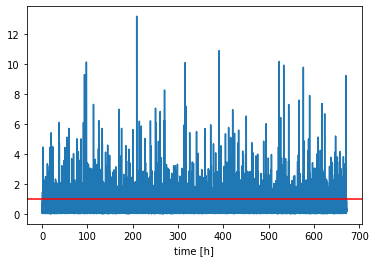

In [11]:
error_dut, error_meas = my_dut.get_errordutcount()
print("Total: ",t, "s ", x+1, " ( ", error_count, " | ", error_dut, " | ", error_meas, " ) ==> ", (x+1-error_count)/(x+1) )
print(my_err)
# write json log
# outfile = open('result.json', 'w')
# json.dump(data, outfile, indent=2)

# plot results
timeAxis = [x / 3600. for x in X]
plt.xlabel('time [h]')
plt.plot(timeAxis,Y)
plt.axhline(y=1., xmin=0, xmax=1, color='r')
plt.show()